SVM MODEL

In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [71]:
data = pd.read_csv('city_market_tracker_EDA.tsv', sep="\t")

In [4]:
data.head()

,PERIOD_BEGIN,PERIOD_END,PERIOD_DURATION,REGION_TYPE,REGION_TYPE_ID,TABLE_ID,IS_SEASONALLY_ADJUSTED,REGION,CITY,STATE,...,SOLD_ABOVE_LIST_YOY,PRICE_DROPS,PRICE_DROPS_MOM,PRICE_DROPS_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,PARENT_METRO_REGION,PARENT_METRO_REGION_METRO_CODE,LAST_UPDATED
0,2019-09-01,2019-09-30,30,place,6,20714,False,"West Pittston, PA",West Pittston,Pennsylvania,...,0.000000,0.274576,0.004459,0.007178,0.0,0.000000,0.000000,"Scranton, PA",42540,2025-09-26 14:45:14.874 Z
1,2016-04-01,2016-04-30,30,place,6,23715,False,"Lakewood, SC",Lakewood,South Carolina,...,0.013004,0.274576,0.004459,0.007178,0.0,-0.000363,0.023477,"Sumter, SC",44940,2025-09-26 14:45:14.874 Z
2,2017-07-01,2017-07-31,30,place,6,18497,False,"Silver Lake, OH",Silver Lake,Ohio,...,0.000000,0.272727,-0.277273,-0.249012,0.5,0.300000,0.250000,"Akron, OH",10420,2025-09-26 14:45:14.874 Z
3,2016-12-01,2016-12-31,30,place,6,15709,False,"Palmyra, WI",Palmyra,Wisconsin,...,0.000000,0.111111,0.020202,0.052288,0.0,-0.666667,0.000000,"Watertown, WI",48020,2025-09-26 14:45:14.874 Z
4,2022-03-01,2022-03-31,30,place,6,8708,False,"Huttig, AR",Huttig,Arkansas,...,0.013004,0.274576,0.004459,0.007178,0.0,-0.000363,0.023477,"El Dorado, AR",20980,2025-09-26 14:45:14.874 Z


In [5]:
data.columns

Index(['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE',
       'REGION_TYPE_ID', 'TABLE_ID', 'IS_SEASONALLY_ADJUSTED', 'REGION',
       'CITY', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'PROPERTY_TYPE_ID',
       'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY',
       'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY',
       'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF',
       'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD',
       'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES',
       'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS',
       'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM',
       'INVENTORY_YOY', 'MONTHS_OF_SUPPLY', 'MONTHS_OF_SUPPLY_MOM',
       'MONTHS_OF_SUPPLY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM',
       'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM',
       'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM',
 

In [74]:
# We are only using California for this model
# Note all columns have is_seasonally_adjusted set to false
# All columns have region_type est to 'place'
# Keeping only relevant, non-repeating information columns that aren't a feature related to median list price
svm_df = data[data['STATE'] == 'California']
svm_df = svm_df[['PERIOD_BEGIN', 'CITY', 'PROPERTY_TYPE', 'HOMES_SOLD', 'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES_MOM', 
           'PENDING_SALES_YOY', 'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'MONTHS_OF_SUPPLY_MOM', 'MONTHS_OF_SUPPLY_YOY',
           'MEDIAN_DOM', 'MEDIAN_DOM_MOM', 'MEDIAN_DOM_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM', 'SOLD_ABOVE_LIST_YOY',
           'PRICE_DROPS', 'PRICE_DROPS_MOM', 'PRICE_DROPS_YOY', 'OFF_MARKET_IN_TWO_WEEKS', 'OFF_MARKET_IN_TWO_WEEKS_MOM',
           'OFF_MARKET_IN_TWO_WEEKS_YOY', 'MEDIAN_SALE_PRICE']]
svm_df.head()

,PERIOD_BEGIN,CITY,PROPERTY_TYPE,HOMES_SOLD,HOMES_SOLD_MOM,HOMES_SOLD_YOY,PENDING_SALES_MOM,PENDING_SALES_YOY,NEW_LISTINGS_MOM,NEW_LISTINGS_YOY,...,SOLD_ABOVE_LIST,SOLD_ABOVE_LIST_MOM,SOLD_ABOVE_LIST_YOY,PRICE_DROPS,PRICE_DROPS_MOM,PRICE_DROPS_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,MEDIAN_SALE_PRICE
12,2016-10-01,Hughson,Single Family Residential,10.0,0.666667,0.111111,0.000000,0.125000,-0.500000,-0.428571,...,0.200000,0.200000,-0.022222,0.166667,-0.476190,-0.333333,0.333333,0.222222,0.083333,315000.0
20,2017-12-01,Aptos,Multi-Family (2-4 Unit),1.0,0.224584,0.261683,0.195562,0.269113,0.226750,0.236910,...,0.000000,0.000732,0.013004,0.274576,0.004459,0.007178,0.000000,-0.000363,0.023477,1649000.0
23,2019-07-01,Lake San Marcos,Single Family Residential,6.0,-0.333333,-0.142857,-0.111111,-0.333333,0.833333,-0.083333,...,0.000000,0.000000,-0.285714,0.411765,-0.321569,-0.121569,0.375000,0.375000,0.125000,773250.0
30,2024-06-01,Linda,All Residential,19.0,-0.240000,0.000000,0.272727,0.076923,-0.125000,0.750000,...,0.315789,-0.244211,-0.368421,0.277778,-0.018519,0.180217,0.285714,0.058442,-0.098901,425000.0
45,2016-05-01,Portola Valley,All Residential,10.0,2.333333,2.333333,1.000000,3.000000,-0.357143,1.250000,...,0.700000,0.033333,0.033333,0.428571,0.295238,0.142857,0.416667,-0.250000,-0.250000,2817500.0


In [79]:
# Transform PERIOD_BEGIN to a float that can be used for SVM model
svm_df['DATETIME'] = pd.to_datetime(svm_df['PERIOD_BEGIN'])
svm_df['DATETIME_DELTA'] = (svm_df['DATETIME'] - svm_df['DATETIME'].min())  / np.timedelta64(1,'D') / 365.25 + 2012
svm_df = svm_df.drop(columns=['PERIOD_BEGIN', 'DATETIME'])
svm_df.head()

,CITY,PROPERTY_TYPE,HOMES_SOLD,HOMES_SOLD_MOM,HOMES_SOLD_YOY,PENDING_SALES_MOM,PENDING_SALES_YOY,NEW_LISTINGS_MOM,NEW_LISTINGS_YOY,MONTHS_OF_SUPPLY_MOM,...,SOLD_ABOVE_LIST_MOM,SOLD_ABOVE_LIST_YOY,PRICE_DROPS,PRICE_DROPS_MOM,PRICE_DROPS_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,MEDIAN_SALE_PRICE,DATETIME_DELTA
12,Hughson,Single Family Residential,10.0,0.666667,0.111111,0.000000,0.125000,-0.500000,-0.428571,-1.700000,...,0.200000,-0.022222,0.166667,-0.476190,-0.333333,0.333333,0.222222,0.083333,315000.0,2016.750171
20,Aptos,Multi-Family (2-4 Unit),1.0,0.224584,0.261683,0.195562,0.269113,0.226750,0.236910,-0.093155,...,0.000732,0.013004,0.274576,0.004459,0.007178,0.000000,-0.000363,0.023477,1649000.0,2017.916496
23,Lake San Marcos,Single Family Residential,6.0,-0.333333,-0.142857,-0.111111,-0.333333,0.833333,-0.083333,1.100000,...,0.000000,-0.285714,0.411765,-0.321569,-0.121569,0.375000,0.375000,0.125000,773250.0,2019.496235
30,Linda,All Residential,19.0,-0.240000,0.000000,0.272727,0.076923,-0.125000,0.750000,0.600000,...,-0.244211,-0.368421,0.277778,-0.018519,0.180217,0.285714,0.058442,-0.098901,425000.0,2024.416153
45,Portola Valley,All Residential,10.0,2.333333,2.333333,1.000000,3.000000,-0.357143,1.250000,-3.600000,...,0.033333,0.033333,0.428571,0.295238,0.142857,0.416667,-0.250000,-0.250000,2817500.0,2016.331280


In [ ]:
# # Transform categorical variables CITY and PROPERTY_TYPE via OneHotEncoder
# categorical_cols = ['CITY', 'PROPERTY_TYPE']
# ohe = OneHotEncoder(sparse_output=False)

# ohe_array = ohe.fit_transform(df[categorical_cols])
# print("OHE feature names:", ohe.get_feature_names_out(categorical_cols))

# ohe_df = pd.DataFrame(
#     ohe_array, columns=ohe.get_feature_names_out(categorical_cols))
# df_ohe = pd.concat([svm_df.reset_index(drop=True), ohe_df], axis=1)
# print(df_ohe.head())

OHE feature names: ['CITY_Acalanes Ridge' 'CITY_Acampo' 'CITY_Acton' ...
 'PROPERTY_TYPE_Multi-Family (2-4 Unit)'
 'PROPERTY_TYPE_Single Family Residential' 'PROPERTY_TYPE_Townhouse']
  PERIOD_BEGIN             CITY              PROPERTY_TYPE  HOMES_SOLD  \
0   2016-10-01          Hughson  Single Family Residential        10.0   
1   2017-12-01            Aptos    Multi-Family (2-4 Unit)         1.0   
2   2019-07-01  Lake San Marcos  Single Family Residential         6.0   
3   2024-06-01            Linda            All Residential        19.0   
4   2016-05-01   Portola Valley            All Residential        10.0   

   HOMES_SOLD_MOM  HOMES_SOLD_YOY  PENDING_SALES_MOM  PENDING_SALES_YOY  \
0        0.666667        0.111111           0.000000           0.125000   
1        0.224584        0.261683           0.195562           0.269113   
2       -0.333333       -0.142857          -0.111111          -0.333333   
3       -0.240000        0.000000           0.272727           0.076923

In [82]:
# Drop city column for now, One Hot Encoding this variable crashes Linear SVM model fitter
svm_df = svm_df.drop(columns=['CITY'])

In [83]:
# Transform categorical variable PROPERTY_TYPE via OneHotEncoder
categorical_cols = ['PROPERTY_TYPE']
ohe = OneHotEncoder(sparse_output=False)


ohe_array = ohe.fit_transform(svm_df[categorical_cols])
print("OHE feature names:", ohe.get_feature_names_out(categorical_cols))

ohe_df = pd.DataFrame(
    ohe_array, columns=ohe.get_feature_names_out(categorical_cols))
df_ohe = pd.concat([svm_df.reset_index(drop=True), ohe_df], axis=1)
print(df_ohe.head())

OHE feature names: ['PROPERTY_TYPE_All Residential' 'PROPERTY_TYPE_Condo/Co-op'
 'PROPERTY_TYPE_Multi-Family (2-4 Unit)'
 'PROPERTY_TYPE_Single Family Residential' 'PROPERTY_TYPE_Townhouse']
               PROPERTY_TYPE  HOMES_SOLD  HOMES_SOLD_MOM  HOMES_SOLD_YOY  \
0  Single Family Residential        10.0        0.666667        0.111111   
1    Multi-Family (2-4 Unit)         1.0        0.224584        0.261683   
2  Single Family Residential         6.0       -0.333333       -0.142857   
3            All Residential        19.0       -0.240000        0.000000   
4            All Residential        10.0        2.333333        2.333333   

   PENDING_SALES_MOM  PENDING_SALES_YOY  NEW_LISTINGS_MOM  NEW_LISTINGS_YOY  \
0           0.000000           0.125000         -0.500000         -0.428571   
1           0.195562           0.269113          0.226750          0.236910   
2          -0.111111          -0.333333          0.833333         -0.083333   
3           0.272727           0.076

In [85]:
df_ohe.head()

,PROPERTY_TYPE,HOMES_SOLD,HOMES_SOLD_MOM,HOMES_SOLD_YOY,PENDING_SALES_MOM,PENDING_SALES_YOY,NEW_LISTINGS_MOM,NEW_LISTINGS_YOY,MONTHS_OF_SUPPLY_MOM,MONTHS_OF_SUPPLY_YOY,...,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,MEDIAN_SALE_PRICE,DATETIME_DELTA,PROPERTY_TYPE_All Residential,PROPERTY_TYPE_Condo/Co-op,PROPERTY_TYPE_Multi-Family (2-4 Unit),PROPERTY_TYPE_Single Family Residential,PROPERTY_TYPE_Townhouse
0,Single Family Residential,10.0,0.666667,0.111111,0.000000,0.125000,-0.500000,-0.428571,-1.700000,-1.400000,...,0.333333,0.222222,0.083333,315000.0,2016.750171,0.0,0.0,0.0,1.0,0.0
1,Multi-Family (2-4 Unit),1.0,0.224584,0.261683,0.195562,0.269113,0.226750,0.236910,-0.093155,-0.419299,...,0.000000,-0.000363,0.023477,1649000.0,2017.916496,0.0,0.0,1.0,0.0,0.0
2,Single Family Residential,6.0,-0.333333,-0.142857,-0.111111,-0.333333,0.833333,-0.083333,1.100000,0.700000,...,0.375000,0.375000,0.125000,773250.0,2019.496235,0.0,0.0,0.0,1.0,0.0
3,All Residential,19.0,-0.240000,0.000000,0.272727,0.076923,-0.125000,0.750000,0.600000,0.600000,...,0.285714,0.058442,-0.098901,425000.0,2024.416153,1.0,0.0,0.0,0.0,0.0
4,All Residential,10.0,2.333333,2.333333,1.000000,3.000000,-0.357143,1.250000,-3.600000,-0.900000,...,0.416667,-0.250000,-0.250000,2817500.0,2016.331280,1.0,0.0,0.0,0.0,0.0


In [90]:
# find best svm parameter c, gamma

C_range = [1e-2, 1, 1e2]
gamma_range = [1e-1, 1, 1e1]
classifiers = []

train, test = train_test_split(df_ohe, test_size=0.25)
x_train = pd.DataFrame(train).drop(columns=['PROPERTY_TYPE', 'MEDIAN_SALE_PRICE'])
y_train = pd.DataFrame(train)['MEDIAN_SALE_PRICE']
x_test = pd.DataFrame(test).drop(columns=['PROPERTY_TYPE', 'MEDIAN_SALE_PRICE'])
y_test = pd.DataFrame(test)['MEDIAN_SALE_PRICE']

for C in C_range:
    for gamma in gamma_range:
        clf = LinearSVR()
        clf.fit(x_train, y_train)
        score = clf.score(x_test, y_test)
        classifiers.append((C, gamma, score, clf))
        print("Iteration done for C = " + str(C) + " and gamma = " + str(gamma))

np.array(classifiers)[:,:3]

Training linear svm model
Iteration done for C = 0.01 and gamma = 0.1
Training linear svm model
Iteration done for C = 0.01 and gamma = 1
Training linear svm model
Iteration done for C = 0.01 and gamma = 10.0
Training linear svm model
Iteration done for C = 1 and gamma = 0.1
Training linear svm model
Iteration done for C = 1 and gamma = 1
Training linear svm model
Iteration done for C = 1 and gamma = 10.0
Training linear svm model
Iteration done for C = 100.0 and gamma = 0.1
Training linear svm model
Iteration done for C = 100.0 and gamma = 1
Training linear svm model
Iteration done for C = 100.0 and gamma = 10.0


array([[0.01, 0.1, -0.06474569235284644],
       [0.01, 1, -0.06609506185650482],
       [0.01, 10.0, -0.06907486821101605],
       [1, 0.1, -0.06840023022184294],
       [1, 1, -0.06514190219493554],
       [1, 10.0, -0.06708232886750798],
       [100.0, 0.1, -0.0631827869872823],
       [100.0, 1, -0.06772085749506562],
       [100.0, 10.0, -0.06690253224683484]], dtype=object)

PERSONAL DATA EXPLORATION

In [18]:
data['PARENT_METRO_REGION'].unique()

array(['Scranton, PA', 'Sumter, SC', 'Akron, OH', 'Watertown, WI',
       'El Dorado, AR', 'Boston, MA', 'Saginaw, MI', 'Columbus, IN',
       'Peoria, IL', 'Knoxville, TN', 'Weatherford, OK', 'Toledo, OH',
       'Modesto, CA', 'Fort Collins, CO', 'Ogden, UT', 'Richmond, VA',
       'Auburn, NY', 'Raleigh, NC', 'Frederick, MD', 'Santa Cruz, CA',
       'New Orleans, LA', 'Safford, AZ', 'San Diego, CA', 'Tampa, FL',
       'New Brunswick, NJ', 'Atlanta, GA', 'Portland, ME', 'Canton, OH',
       'Yuba City, CA', 'Miami, OK', 'Minneapolis, MN', 'Vineland, NJ',
       'Traverse City, MI', 'Montgomery County, PA', 'Sierra Vista, AZ',
       'Parkersburg, WV', 'Houston, TX', 'Huntington, WV', 'Reading, PA',
       'Gettysburg, PA', 'Brainerd, MN', 'Sheboygan, WI',
       'San Francisco, CA', 'Sonora, CA', 'Madison, WI', 'Miami, FL',
       'Santa Fe, NM', 'Worcester, MA', 'Lake County, IL',
       'St. Louis, MO', 'Chicago, IL', 'Los Angeles, CA',
       'West Palm Beach, FL', 'Sterling, IL

In [13]:
data['STATE'].value_counts()

STATE
California        476473
New York          446847
Pennsylvania      414272
Florida           374792
Illinois          291661
Ohio              282730
Texas             271275
Massachusetts     241800
New Jersey        236304
Washington        177540
Maryland          169010
North Carolina    167394
Michigan          165893
Virginia          149568
Minnesota         140380
Wisconsin         135854
Indiana           123845
Georgia           119715
Missouri          117625
Colorado          105148
Oregon            100441
Alabama            89330
Tennessee          88010
South Carolina     80449
Kentucky           79390
Iowa               72961
Arizona            72598
Utah               72238
Connecticut        71565
Louisiana          66940
Oklahoma           60917
Arkansas           53035
Kansas             51041
Hawaii             48912
Idaho              36470
New Hampshire      35363
West Virginia      34456
Mississippi        34420
Rhode Island       29131
Nebraska           

In [18]:
t = data[data['STATE'] == 'California']
t['REGION'].value_counts()

REGION
Burbank, CA           1165
Mountain View, CA     1116
Live Oak, CA           991
El Cerrito, CA         898
Spring Valley, CA      884
                      ... 
Yettem, CA               2
Essex, CA                2
South Coyote, CA         2
Ocotillo Wells, CA       2
Platina, CA              2
Name: count, Length: 1415, dtype: int64

In [ ]:
# EDA - Graphing top 5 california cities as time series to median sale price to get idea of graph
eda = data[data['STATE'] == 'California']
top = eda['CITY'].value_counts().head(5).index.to_list()

In [ ]:
top_df = eda[eda['CITY'].isin(top)]
top_df['DATETIME'] = pd.to_datetime(top_df['PERIOD_BEGIN'])
top_df['DATETIME_DELTA'] = (top_df['DATETIME'] - top_df['DATETIME'].min())  / np.timedelta64(1,'D') / 365.25 + 2012

C:\Users\Carsa\AppData\Local\Temp\ipykernel_32080\506374223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['DATETIME'] = pd.to_datetime(top_df['PERIOD_BEGIN'])
C:\Users\Carsa\AppData\Local\Temp\ipykernel_32080\506374223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_df['DATETIME_DELTA'] = (top_df['DATETIME'] - top_df['DATETIME'].min())  / np.timedelta64(1,'D') / 365.25 + 2012


In [57]:
top_df.sort_values('DATETIME_DELTA', ascending=True)

,PERIOD_BEGIN,PERIOD_END,PERIOD_DURATION,REGION_TYPE,REGION_TYPE_ID,TABLE_ID,IS_SEASONALLY_ADJUSTED,REGION,CITY,STATE,...,PRICE_DROPS_MOM,PRICE_DROPS_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,PARENT_METRO_REGION,PARENT_METRO_REGION_METRO_CODE,LAST_UPDATED,DATETIME,DATETIME_DELTA
4233124,2012-01-01,2012-01-31,30,place,6,12739,False,"Mountain View, CA",Mountain View,California,...,0.030769,-0.128571,0.066667,-0.387879,-0.044444,"San Jose, CA",41940,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
5472907,2012-01-01,2012-01-31,30,place,6,12739,False,"Mountain View, CA",Mountain View,California,...,0.004459,0.100000,0.666667,-0.000363,0.666667,"San Jose, CA",41940,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
3308182,2012-01-01,2012-01-31,30,place,6,12739,False,"Mountain View, CA",Mountain View,California,...,0.099444,-0.031321,0.366667,0.015315,0.116667,"San Jose, CA",41940,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
3429968,2012-01-01,2012-01-31,30,place,6,2320,False,"Burbank, CA",Burbank,California,...,-0.050505,-0.107323,0.236364,0.163193,0.109091,"Los Angeles, CA",31084,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
1799806,2012-01-01,2012-01-31,30,place,6,24455,False,"Mountain View, CA",Mountain View,California,...,0.200000,0.038462,0.333333,0.333333,0.333333,"Oakland, CA",36084,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877813,2025-08-01,2025-08-31,30,place,6,24455,False,"Mountain View, CA",Mountain View,California,...,0.150000,-0.600000,0.333333,0.047619,0.333333,"Oakland, CA",36084,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478
2891775,2025-08-01,2025-08-31,30,place,6,2320,False,"Burbank, CA",Burbank,California,...,0.077778,0.090000,0.230769,-0.038462,-0.117057,"Los Angeles, CA",31084,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478
5106842,2025-08-01,2025-08-31,30,place,6,12739,False,"Mountain View, CA",Mountain View,California,...,0.205128,0.181319,0.562500,0.133929,0.437500,"San Jose, CA",41940,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478
4847751,2025-08-01,2025-08-31,30,place,6,26127,False,"Spring Valley, CA",Spring Valley,California,...,0.004459,0.007178,0.239557,-0.000363,0.023477,"San Diego, CA",41740,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478


In [58]:
graph_df = top_df[['DATETIME_DELTA', 'MEDIAN_SALE_PRICE', 'CITY']]
groups = graph_df.groupby('CITY')

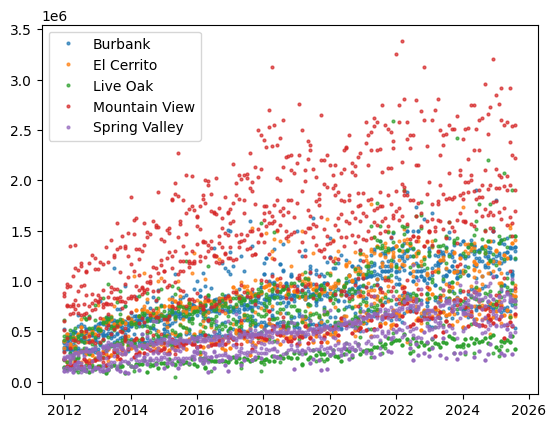

In [61]:
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group, in groups:
    ax.plot(group.DATETIME_DELTA, group.MEDIAN_SALE_PRICE, marker='o', 
            linestyle = '', ms=2, alpha=0.7, label=name)
ax.legend()

plt.show()

In [67]:
# Plot 1% of data for EDA
graph_df = eda.iloc[::100, :]
graph_df['DATETIME'] = pd.to_datetime(graph_df['PERIOD_BEGIN'])
graph_df['DATETIME_DELTA'] = (graph_df['DATETIME'] - graph_df['DATETIME'].min())  / np.timedelta64(1,'D') / 365.25 + 2012

C:\Users\Carsa\AppData\Local\Temp\ipykernel_32080\282131159.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['DATETIME'] = pd.to_datetime(graph_df['PERIOD_BEGIN'])
C:\Users\Carsa\AppData\Local\Temp\ipykernel_32080\282131159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['DATETIME_DELTA'] = (graph_df['DATETIME'] - graph_df['DATETIME'].min())  / np.timedelta64(1,'D') / 365.25 + 2012


In [68]:
graph_df.sort_values('DATETIME_DELTA', ascending=True)

,PERIOD_BEGIN,PERIOD_END,PERIOD_DURATION,REGION_TYPE,REGION_TYPE_ID,TABLE_ID,IS_SEASONALLY_ADJUSTED,REGION,CITY,STATE,...,PRICE_DROPS_MOM,PRICE_DROPS_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,PARENT_METRO_REGION,PARENT_METRO_REGION_METRO_CODE,LAST_UPDATED,DATETIME,DATETIME_DELTA
1017526,2012-01-01,2012-01-31,30,place,6,35671,False,"Greenacres, CA",Greenacres,California,...,0.004459,0.007178,0.000000,0.000000,-0.250000,"Bakersfield, CA",12540,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
3305898,2012-01-01,2012-01-31,30,place,6,998,False,"Baldwin Park, CA",Baldwin Park,California,...,0.004459,0.007178,0.000000,-0.500000,0.000000,"Los Angeles, CA",31084,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
1907031,2012-01-01,2012-01-31,30,place,6,23650,False,"Ladera Heights, CA",Ladera Heights,California,...,0.218182,0.282353,0.333333,-0.041667,0.023477,"Los Angeles, CA",31084,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
2630758,2012-01-01,2012-01-31,30,place,6,28692,False,"Chatsworth Lake Manor, CA",Chatsworth Lake Manor,California,...,0.004459,0.007178,0.000000,-0.000363,0.023477,"Los Angeles, CA",31084,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
1870420,2012-01-01,2012-01-31,30,place,6,12596,False,"Moraga, CA",Moraga,California,...,-0.125000,-0.342905,0.166667,0.041667,0.000000,"Oakland, CA",36084,2025-09-26 14:45:14.874 Z,2012-01-01,2012.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193430,2025-08-01,2025-08-31,30,place,6,3115,False,"Cathedral City, CA",Cathedral City,California,...,0.031794,0.017595,0.181818,0.083779,-0.045455,"Riverside, CA",40140,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478
927327,2025-08-01,2025-08-31,30,place,6,12596,False,"Moraga, CA",Moraga,California,...,0.150000,0.114286,0.000000,0.000000,0.000000,"Oakland, CA",36084,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478
851167,2025-08-01,2025-08-31,30,place,6,25046,False,"Pollock Pines, CA",Pollock Pines,California,...,-0.053911,-0.104040,0.294118,0.160784,0.169118,"Sacramento, CA",40900,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478
374410,2025-08-01,2025-08-31,30,place,6,32416,False,"East Rancho Dominguez, CA",East Rancho Dominguez,California,...,0.004459,0.007178,0.239557,-0.000363,0.023477,"Los Angeles, CA",31084,2025-09-26 14:45:14.874 Z,2025-08-01,2025.582478


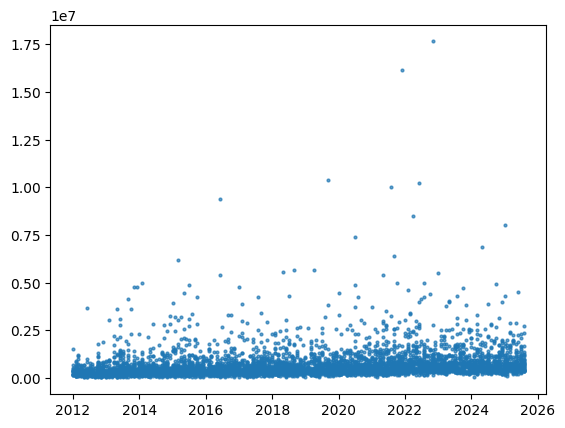

In [69]:
fig, ax = plt.subplots()
ax.margins(0.05)
ax.plot(graph_df.DATETIME_DELTA, graph_df.MEDIAN_SALE_PRICE,  marker='o', 
            linestyle = '', ms=2, alpha=0.7)
plt.show()